In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.datasets import load_breast_cancer
from sklearn.pipeline import Pipeline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Set random seed for reproducibility
np.random.seed(42)

# Load the breast cancer dataset
data = load_breast_cancer()
X = data.data
y = data.target

# Print dataset information
print(f"Dataset shape: {X.shape}")
print(f"Number of features: {X.shape[1]}")
print(f"Number of classes: {len(np.unique(y))}")
print(f"Class distribution: {np.bincount(y)}")

Dataset shape: (569, 30)
Number of features: 30
Number of classes: 2
Class distribution: [212 357]


In [4]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [6]:
# Basic AdaBoost model with default parameters
print("\n--- Basic AdaBoost Model ---")
base_model = AdaBoostClassifier(random_state=42)
base_model.fit(X_train_scaled, y_train)
y_pred = base_model.predict(X_test_scaled)

print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


--- Basic AdaBoost Model ---
Accuracy: 0.9649

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.93      0.95        43
           1       0.96      0.99      0.97        71

    accuracy                           0.96       114
   macro avg       0.97      0.96      0.96       114
weighted avg       0.97      0.96      0.96       114



In [8]:
# Grid search for hyperparameter tuning
print("\n--- Grid Search for Hyperparameter Tuning ---")
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1.0],
    'estimator__max_depth': [1, 3, 5]
}

# Create base estimator
base_estimator = DecisionTreeClassifier(random_state=42)

# Create AdaBoost model
adaboost = AdaBoostClassifier(estimator=base_estimator, random_state=42)

# Create grid search
grid_search = GridSearchCV(
    estimator=adaboost,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    scoring='accuracy',
    verbose=1
)

# Fit grid search
grid_search.fit(X_train_scaled, y_train)

# Print best parameters and score
print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")


--- Grid Search for Hyperparameter Tuning ---
Fitting 5 folds for each of 27 candidates, totalling 135 fits

Best parameters: {'estimator__max_depth': 1, 'learning_rate': 1.0, 'n_estimators': 50}
Best cross-validation score: 0.9802


In [14]:
# Train model with best parameters
best_model = grid_search.best_estimator_ # Make predictions
y_pred_best = best_model.predict(X_test_scaled)

In [15]:
# Make predictions
y_pred_best = best_model.predict(X_test_scaled)
print(f"\nTest accuracy with best model: {accuracy_score(y_test, y_pred_best):.4f}")


Test accuracy with best model: 0.9649



--- Feature Importances ---


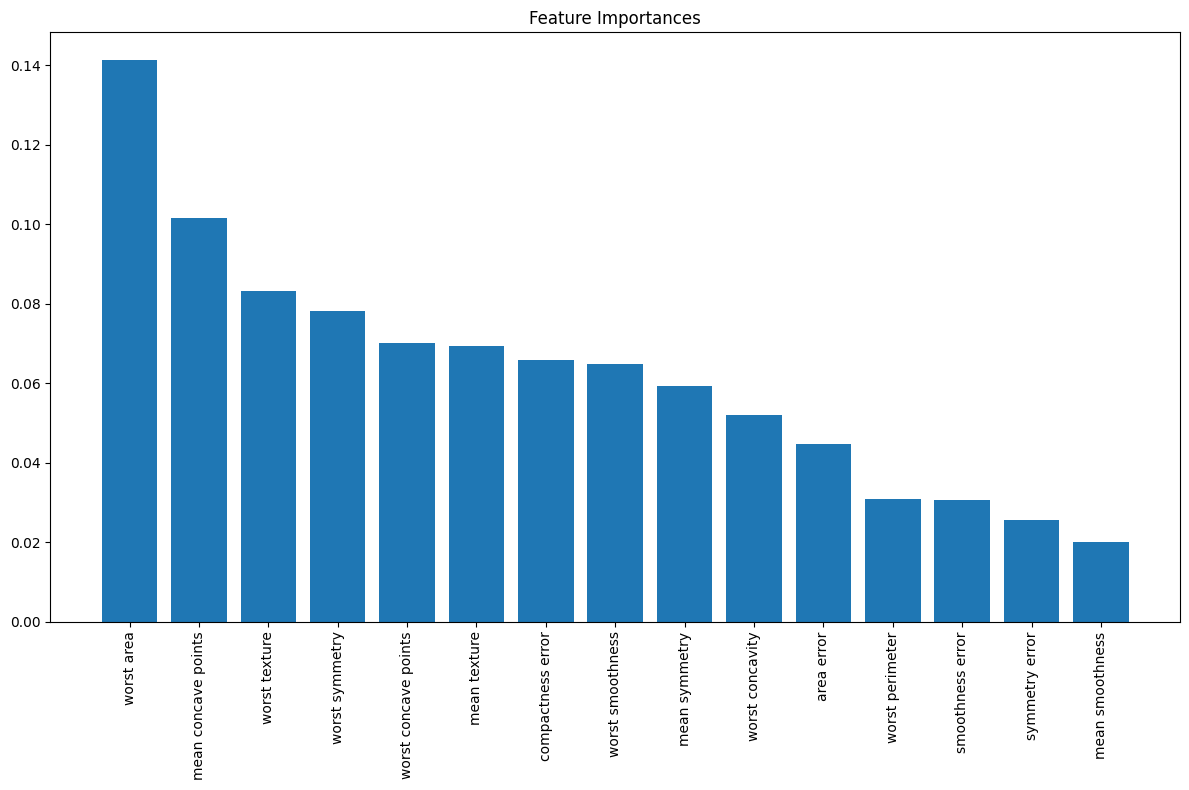

In [17]:
# Visualize feature importances
def plot_feature_importance(model, feature_names):
    # For AdaBoost, feature_importances_ is available after fitting
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
    else:
        # For pipeline, need to access the classifier
        importances = model.named_steps['adaboost'].feature_importances_
    
    indices = np.argsort(importances)[::-1]
    
    plt.figure(figsize=(12, 8))
    plt.title('Feature Importances')
    plt.bar(range(len(indices[:15])), importances[indices[:15]], align='center')
    plt.xticks(range(len(indices[:15])), [feature_names[i] for i in indices[:15]], rotation=90)
    plt.tight_layout()
    plt.savefig('Adaboost_feature_importances')
    plt.show()

print("\n--- Feature Importances ---")
plot_feature_importance(best_model, data.feature_names)


--- Confusion Matrix ---


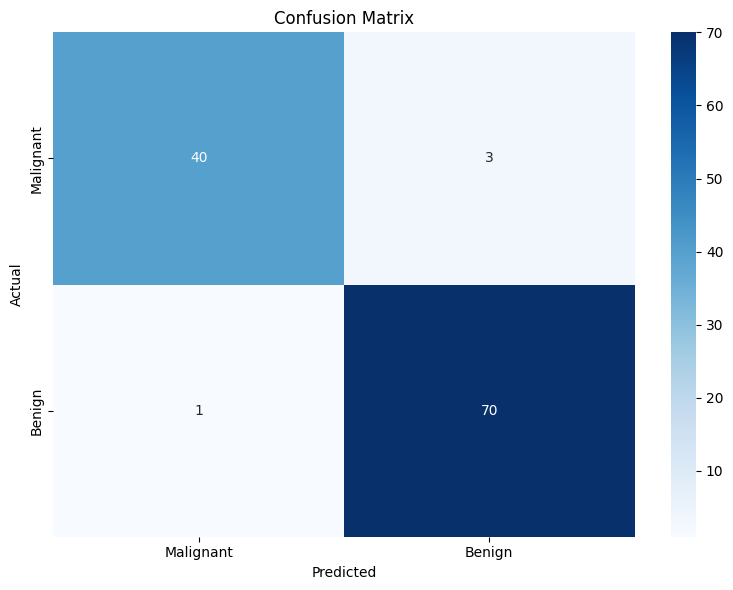

In [18]:
# Visualize confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.savefig('Adaboost_Confusion_Matrix')
    plt.show()

print("\n--- Confusion Matrix ---")
plot_confusion_matrix(y_test, y_pred_best, ['Malignant', 'Benign'])


--- ROC Curve ---


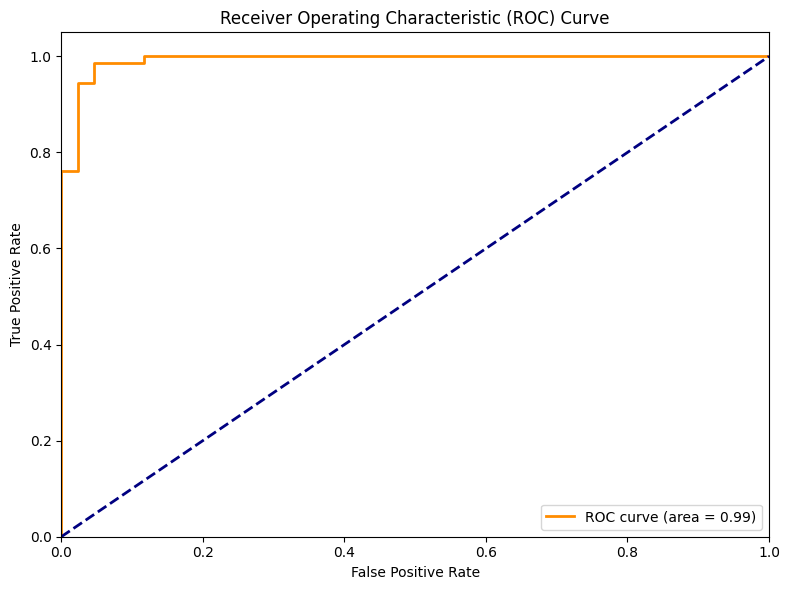

In [19]:
# ROC curve
def plot_roc_curve(model, X, y):
    y_score = model.predict_proba(X)[:, 1]
    fpr, tpr, _ = roc_curve(y, y_score)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.savefig('Adaboost_Roc_Curve')
    plt.show()

print("\n--- ROC Curve ---")
plot_roc_curve(best_model, X_test_scaled, y_test)

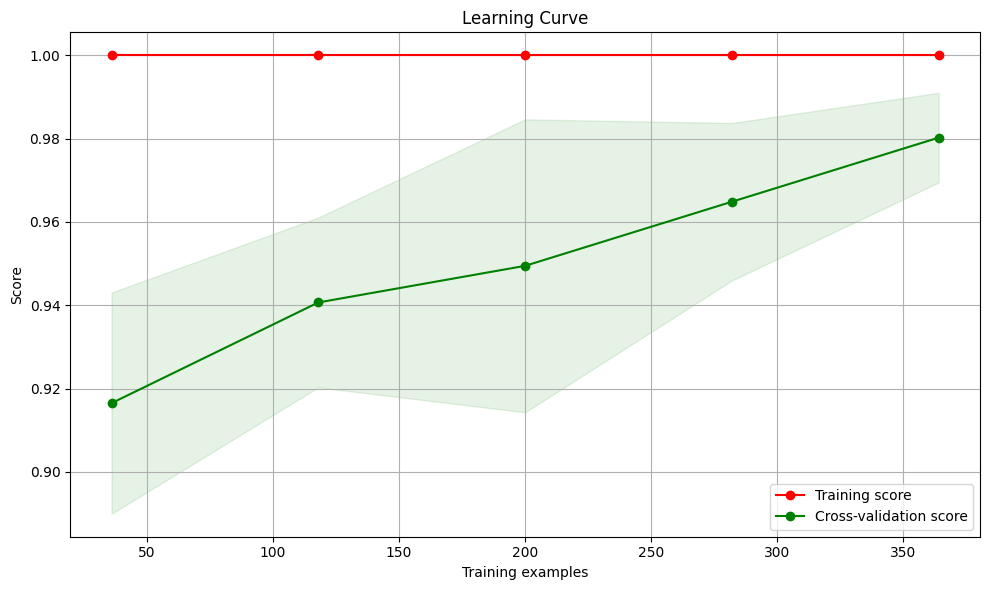


--- Learning Curve ---


In [21]:
# Learning curve
def plot_learning_curve(estimator, X, y, title="Learning Curve", ylim=None, cv=5, n_jobs=-1):
    plt.figure(figsize=(10, 6))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, 
        train_sizes=np.linspace(.1, 1.0, 5))
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.legend(loc="best")
    plt.tight_layout()
    plt.savefig('Adaboost_Learning_Curve')
    plt.show()

    print("\n--- Learning Curve ---")
plot_learning_curve(best_model, X_train_scaled, y_train)


--- Effect of Learning Rate ---


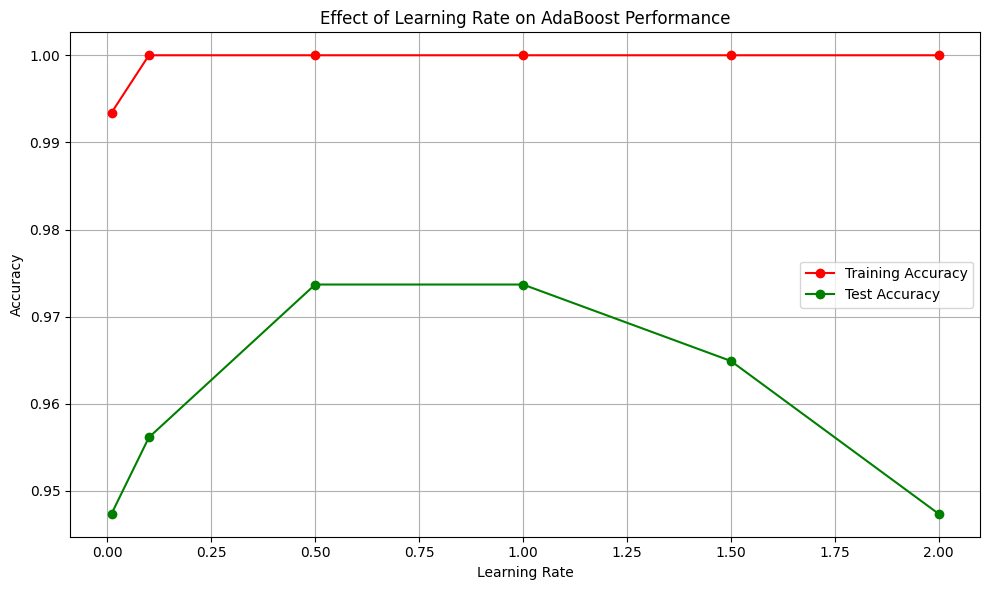

In [22]:
# Effect of different learning rates
def plot_learning_rate_effect():
    learning_rates = [0.01, 0.1, 0.5, 1.0, 1.5, 2.0]
    train_scores = []
    test_scores = []
    
    for lr in learning_rates:
        model = AdaBoostClassifier(
            estimator=DecisionTreeClassifier(max_depth=3),
            n_estimators=100,
            learning_rate=lr,
            random_state=42
        )
        model.fit(X_train_scaled, y_train)
        train_scores.append(accuracy_score(y_train, model.predict(X_train_scaled)))
        test_scores.append(accuracy_score(y_test, model.predict(X_test_scaled)))
    
    plt.figure(figsize=(10, 6))
    plt.plot(learning_rates, train_scores, 'o-', color='r', label='Training Accuracy')
    plt.plot(learning_rates, test_scores, 'o-', color='g', label='Test Accuracy')
    plt.xlabel('Learning Rate')
    plt.ylabel('Accuracy')
    plt.title('Effect of Learning Rate on AdaBoost Performance')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('Adaboost_Learning_Rate')
    plt.show()

print("\n--- Effect of Learning Rate ---")
plot_learning_rate_effect()


--- Effect of Number of Estimators ---


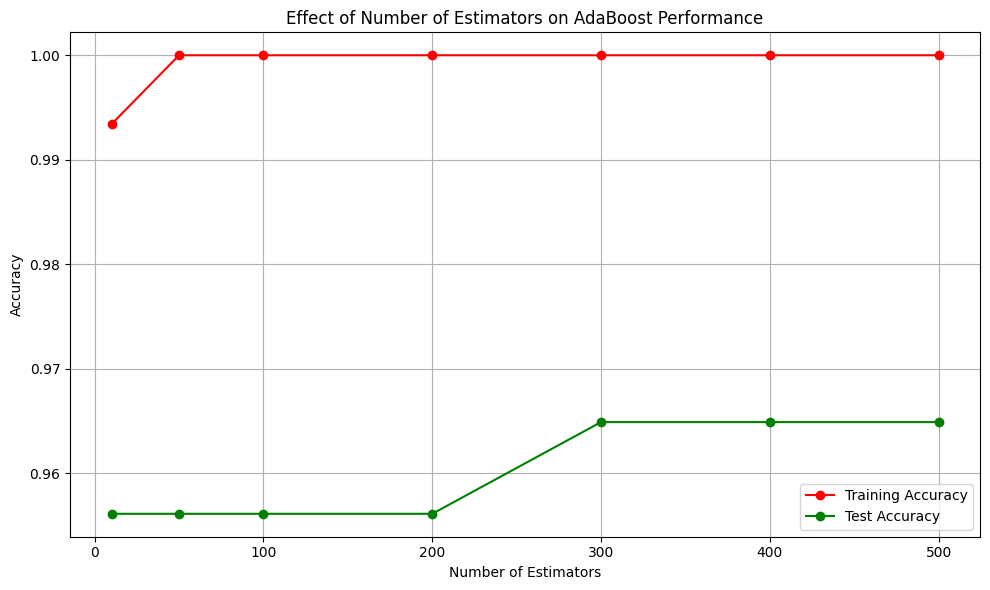

In [23]:
# Effect of number of estimators
def plot_n_estimators_effect():
    n_estimators_range = [10, 50, 100, 200, 300, 400, 500]
    train_scores = []
    test_scores = []
    
    for n_est in n_estimators_range:
        model = AdaBoostClassifier(
            estimator=DecisionTreeClassifier(max_depth=3),
            n_estimators=n_est,
            learning_rate=0.1,
            random_state=42
        )
        model.fit(X_train_scaled, y_train)
        train_scores.append(accuracy_score(y_train, model.predict(X_train_scaled)))
        test_scores.append(accuracy_score(y_test, model.predict(X_test_scaled)))
    
    plt.figure(figsize=(10, 6))
    plt.plot(n_estimators_range, train_scores, 'o-', color='r', label='Training Accuracy')
    plt.plot(n_estimators_range, test_scores, 'o-', color='g', label='Test Accuracy')
    plt.xlabel('Number of Estimators')
    plt.ylabel('Accuracy')
    plt.title('Effect of Number of Estimators on AdaBoost Performance')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('Adaboost_n_estimators')
    plt.show()

print("\n--- Effect of Number of Estimators ---")
plot_n_estimators_effect()

In [24]:
# Pipeline example with AdaBoost
print("\n--- Pipeline with AdaBoost ---")
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('adaboost', AdaBoostClassifier(random_state=42))
])

# Parameters for pipeline
pipeline_params = {
    'adaboost__estimator': [DecisionTreeClassifier(max_depth=1, random_state=42),
                           DecisionTreeClassifier(max_depth=3, random_state=42)],
    'adaboost__n_estimators': [50, 100, 200],
    'adaboost__learning_rate': [0.01, 0.1, 1.0]
}

# Randomized search to speed up the tuning process
random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=pipeline_params,
    n_iter=10,
    cv=5,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1
)

# Fit randomized search
random_search.fit(X_train, y_train)  # Note: Using unscaled data since scaling is part of the pipeline

# Print best parameters
print(f"Best pipeline parameters: {random_search.best_params_}")
print(f"Best cross-validation score: {random_search.best_score_:.4f}")


--- Pipeline with AdaBoost ---
Best pipeline parameters: {'adaboost__n_estimators': 200, 'adaboost__learning_rate': 1.0, 'adaboost__estimator': DecisionTreeClassifier(max_depth=1, random_state=42)}
Best cross-validation score: 0.9780


In [25]:
# Evaluate the best pipeline model
best_pipeline = random_search.best_estimator_
y_pred_pipeline = best_pipeline.predict(X_test)
print(f"\nPipeline test accuracy: {accuracy_score(y_test, y_pred_pipeline):.4f}")


Pipeline test accuracy: 0.9737


In [26]:
# Compare with base model
print("\n--- Model Comparison ---")
print(f"Base AdaBoost accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Grid Search tuned accuracy: {accuracy_score(y_test, y_pred_best):.4f}")
print(f"Pipeline tuned accuracy: {accuracy_score(y_test, y_pred_pipeline):.4f}")


--- Model Comparison ---
Base AdaBoost accuracy: 0.9649
Grid Search tuned accuracy: 0.9649
Pipeline tuned accuracy: 0.9737


In [27]:
# Print final classification report
print("\nFinal Classification Report:")
print(classification_report(y_test, y_pred_pipeline))


Final Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.95      0.96        43
           1       0.97      0.99      0.98        71

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114

